In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import mglearn
from sklearn.model_selection import train_test_split

# クラス分類器の不確実性推定
- scikit-learnには、クラス分類器の不確実性推定に利用できる関数が二つある
    - decision_function：決定関数 → 出力は各データポイントの確信度となり、スケールはデータとモデルパラメータによる
    - predict_proba：確率の予測 → 出力は各データポイントの各クラスの予測確率 → 各クラスの予測確率の合計が1になる
- ほとんどの分類器はどちらかを実装している

In [3]:
# 勾配ブースティングモデルを構築する
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_circles
X, y = make_circles(noise=0.25, factor=0.5, random_state=1)

# わかりやすいようにクラスを"blue"と"red"にする
y_named = np.array(["blue", "red"])[y]

# train_test_splitは任意の数の配列に適用できる
# すべての配列は整合するように分割される
X_train, X_test, y_train_named, y_test_named, y_train, y_test = \
    train_test_split(X, y_named, y, random_state=0)

# 勾配ブースティング（Gradient Boosting Random Tree）モデルを構築
gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train_named)

GradientBoostingClassifier(random_state=0)

## 決定関数

In [4]:
# 決定関数（Decision Function）
print("X_test.shape: {}".format(X_test.shape))
print("Decision function shape: {}".format(
    gbrt.decision_function(X_test).shape))

X_test.shape: (25, 2)
Decision function shape: (25,)


In [17]:
# データポイントの確信度（正であれば陽性、負であれば陰性）
# decition_functionの最初のいくつかを表示
print("Decition function:\n{}".format(gbrt.decision_function(X_test)[:6]))

Decition function:
[ 4.13592603 -1.70169917 -3.95106099 -3.62609552  4.28986642  3.66166081]


In [6]:
# 予測クラスの表示
print("Threshold decition function:\n{}".format(
    gbrt.decision_function(X_test) > 0))
print("Predictions:\n{}".format(gbrt.predict(X_test)))

Threshold decition function:
[ True False False False  True  True False  True  True  True False  True
  True False  True False False False  True  True  True  True  True False
 False]
Predictions:
['red' 'blue' 'blue' 'blue' 'red' 'red' 'blue' 'red' 'red' 'red' 'blue'
 'red' 'red' 'blue' 'red' 'blue' 'blue' 'blue' 'red' 'red' 'red' 'red'
 'red' 'blue' 'blue']


In [12]:
# classes_属性["blue", "red"]を、decision_functionの出力値の正負（第1エントリが負/陰、第2エントリ正/陽）に割り当てる
# True/Falseを0/1に
greater_zero = (gbrt.decision_function(X_test) > 0).astype(int)
# 0/1をclasses_のインデックスに使う
pred = gbrt.classes_[greater_zero]
# predはgbrt.predictの出力と同じになる
print("pred is equal to predictions: {}".format(
    np.all(pred == gbrt.predict(X_test))))

pred is equal to predictions: True


In [14]:
# decition_functionの最小値と最大値
decision_function = gbrt.decision_function(X_test)
print("Decision function minimum: {:.2f} maximum: {:.2f}".format(
    np.min(decision_function), np.max(decision_function)))

Decision function minimum: -7.69 maximum: 4.29


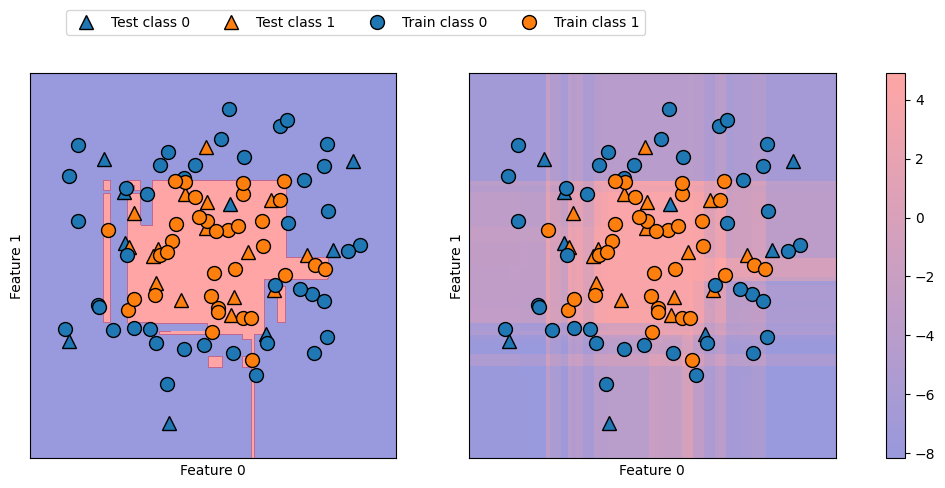

In [16]:
# 決定境界と、すべてのデータポイントに対するdecision_functionの値
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
mglearn.tools.plot_2d_separator(gbrt, X, ax=axes[0], alpha=.4,
                                fill=True, cm=mglearn.cm2)
scores_image = mglearn.tools.plot_2d_scores(gbrt, X, ax=axes[1],
                                            alpha=.4, cm=mglearn.ReBl)

for ax in axes:
    # 訓練データポイントとテストデータポイントをプロット
    mglearn.discrete_scatter(X_test[:, 0], X_test[:, 1], y_test,
                             markers='^', ax=ax)
    mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train,
                             markers='o', ax=ax)
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")
cbar = plt.colorbar(scores_image, ax=axes.tolist())
axes[0].legend(["Test class 0", "Test class 1", "Train class 0",
                "Train class 1"], ncol=4, loc=(.1, 1.1))

## 確率の予測

In [18]:
# predict_probaの出力配列
print("Shape of probabilities: {}".format(gbrt.predict_proba(X_test).shape))

Shape of probabilities: (25, 2)


In [19]:
# 第1クラスの予測確率と、第2クラスの予測確率
# predict_probaの出力の最初の数行を見る
print("Predict probabilities:\n{}".format(
    gbrt.predict_proba(X_test[:6])))

Predict probabilities:
[[0.01573626 0.98426374]
 [0.84575653 0.15424347]
 [0.98112869 0.01887131]
 [0.97407033 0.02592967]
 [0.01352142 0.98647858]
 [0.02504637 0.97495363]]


- 2つのクラスの確率の和が1になり、50%以上の確率になっているクラスが予測クラスになる
- 出力される予測確率が実際のデータポイントに対する正答率を反映しているかどうかは、モデルやパラメータに依存する
    - 過剰適合したモデルは、予測が間違っている場合でも、高い予測確率となる傾向がある
    - 複雑さが低いモデルの予測は、予測確率が低い
- あるモデルが報告する予測確率が、実際の正答率と一致している場合、<font color="red">較正されている（calibrated）</font>という
    - 例えば、70%の予測確率で予測された複数のデータポイントがある場合、70%の確率で正答できている場合に、そのモデルは較正されている

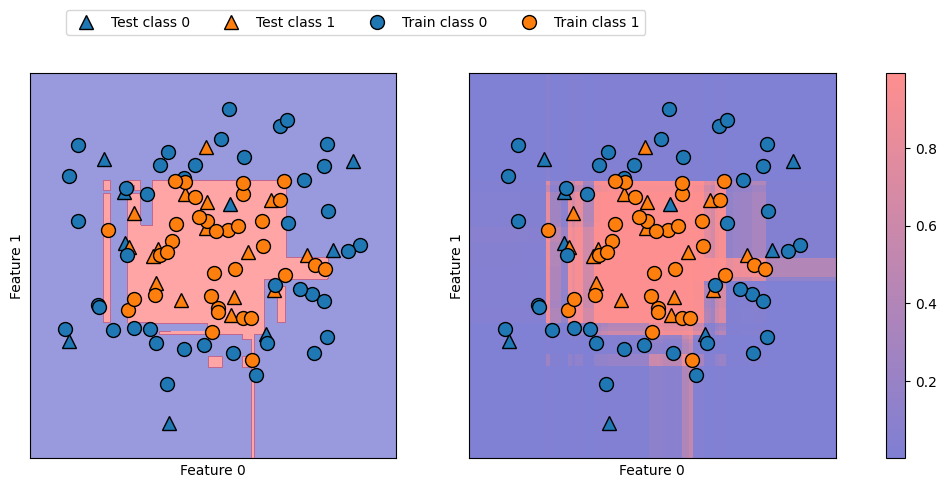

In [21]:
# 決定境界と、すべてのデータポイントに対するクラス1になる確率
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

mglearn.tools.plot_2d_separator(
    gbrt, X, ax=axes[0], alpha=.4, fill=True, cm=mglearn.cm2)
scores_image = mglearn.tools.plot_2d_scores(
    gbrt, X, ax=axes[1], alpha=.5, cm=mglearn.ReBl, function='predict_proba')

for ax in axes:
    # 訓練データポイントとテストデータポイントをプロット
    mglearn.discrete_scatter(X_test[:, 0], X_test[:, 1], y_test,
                             markers='^', ax=ax)
    mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train,
                             markers='o', ax=ax)
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")
cbar = plt.colorbar(scores_image, ax=axes.tolist())
axes[0].legend(["Test class 0", "Test class 1", "Train class 0",
                "Train class 1"], ncol=4, loc=(.1, 1.1))

- 決定境界内でも、Train class 0（<font color="blue">●</font>）が近いあたりでは、予測確率が低くなっている

## 他クラス分類の不確実性

In [22]:
# irisデータセットへの勾配ブースティングモデルの適用
from sklearn.datasets import load_iris
from sklearn.ensemble import GradientBoostingClassifier

iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, random_state=42)

gbrt = GradientBoostingClassifier(learning_rate=0.01, random_state=0)
gbrt.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, random_state=0)

In [23]:
# 決定関数の配列の形状と、値の表示
print("Decision function shape: {}".format(gbrt.decision_function(X_test).shape))
# 決定関数の最初のいくつかを表示
print("Decsion function:\n{}".format(gbrt.decision_function(X_test)[:6, ]))

Decision function shape: (38, 3)
Decsion function:
[[-0.89604809  1.14724958 -0.82754003]
 [ 1.16113086 -0.80789044 -0.82827067]
 [-0.89091511 -0.77671169  1.19653416]
 [-0.89604809  1.14724958 -0.82754003]
 [-0.89763468  0.96497584 -0.10374792]
 [ 1.16113086 -0.80789044 -0.82827067]]


- 他クラス分類では、decision_functionの結果は(n_samples, n_classes)となる
- 予測結果は、確信度スコアが最も大きいクラスになる

In [24]:
# 最大値を持つクラスインデックスと予測値の比較
print("Argmax of decision function:\n{}".format(
    np.argmax(gbrt.decision_function(X_test), axis=1)))
print("Predictions:\n{}".format(gbrt.predict(X_test)))

Argmax of decision function:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]
Predictions:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]


In [25]:
# 予測確率の表示
# predict_probaの結果の最初の数行を表示
print("Predicted probabilities:\n{}".format(gbrt.predict_proba(X_test)[:6]))
# 各行の和が1になることを確認
print("Sums: {}".format(gbrt.predict_proba(X_test)[:6].sum(axis=1)))

Predicted probabilities:
[[0.10217718 0.78840034 0.10942248]
 [0.78347147 0.10936745 0.10716108]
 [0.09818072 0.11005864 0.79176065]
 [0.10217718 0.78840034 0.10942248]
 [0.10360005 0.66723901 0.22916094]
 [0.78347147 0.10936745 0.10716108]]
Sums: [1. 1. 1. 1. 1. 1.]


In [26]:
# 最大の予測値を持つクラスインデックスと予測値の比較
print("Argmax of predicted probabilities:\n{}".format(
    np.argmax(gbrt.predict_proba(X_test), axis=1)))
print("Predictions:\n{}".format(gbrt.predict(X_test)))

Argmax of predicted probabilities:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]
Predictions:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]


In [31]:
# クラス名が文字列の場合の学習と予測
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

# irisデータセットのクラス名で学習する
named_target = iris.target_names[y_train] # インデックスの配列y_trainでクラス名を取り出す
logreg.fit(X_train, named_target)

# クラスの一覧と予測結果
print("unique classes in training data: {}".format(logreg.classes_))
print("predictions: {}".format(logreg.predict(X_test)[:10]))

# decision_functionの結果から予測クラスを判別する
argmax_dec_func = np.argmax(logreg.decision_function(X_test), axis=1)
print("argmax of decision function: {}".format(argmax_dec_func[:10]))
print("argmax combined with classes_: {}".format(
    logreg.classes_[argmax_dec_func][:10]))

# 予測結果と、decision_functionの結果から判別した予測クラスを比較する
print("decided classes is equal to predictions: {}".format(
    np.all(logreg.predict(X_test)[:10] == logreg.classes_[argmax_dec_func][:10])))

unique classes in training data: ['setosa' 'versicolor' 'virginica']
predictions: ['versicolor' 'setosa' 'virginica' 'versicolor' 'versicolor' 'setosa'
 'versicolor' 'virginica' 'versicolor' 'versicolor']
argmax of decision function: [1 0 2 1 1 0 1 2 1 1]
argmax combined with classes_: ['versicolor' 'setosa' 'virginica' 'versicolor' 'versicolor' 'setosa'
 'versicolor' 'virginica' 'versicolor' 'versicolor']
decided classes is equal to predictions: True
